In [304]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

In [305]:
colnames=['date', 'time','destination','student_id', 'cohort',
          'ip' ]
df = pd.read_csv('curriculum-access.txt', engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 1, 2, 3, 4, 5, 6])

In [306]:
df

,date,time,destination,student_id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62
...,...,...,...,...,...,...
543591,2020-05-15,15:01:40,java-ii/file-io,602,56.0,48.188.241.68
543592,2020-05-15,15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38
543593,2020-05-15,15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17
543594,2020-05-15,15:05:14,10-anomaly-detection/3-discrete-probabilistic-...,11,28.0,77.186.132.227


In [307]:
df['datetime'] = df['date'] + ' ' + df['time']
df['datetime'] = pd.to_datetime(df.datetime)
df = df.drop(columns = ['date', 'time'])
df = df.set_index('datetime')
df.head()

,destination,student_id,cohort,ip
datetime,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62
2018-01-26 09:56:02,java-ii,1,8.0,98.106.20.62
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [46]:
curie = df[df.cohort == 55]

In [49]:
curie['count'] = 1

In [51]:
curie_n = curie['count'].resample('1D').sum()

In [52]:
curie_n

datetime
2020-02-03    125
2020-02-04    237
2020-02-05    424
2020-02-06    720
2020-02-07    413
             ... 
2020-05-11    139
2020-05-12     96
2020-05-13     74
2020-05-14     99
2020-05-15     95
Freq: D, Name: count, Length: 103, dtype: int64

In [53]:
span = 7
ema_long = curie_n.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*6
lb = midband - ema_long[-24:-1].std()*6

In [54]:
ub, lb

(271.0872584175518, -83.26321498948522)

In [55]:
midband

93.9120217140333

In [56]:
pct_b = pd.DataFrame({'pct_b': (curie_n-lb)/(ub-lb)})
curie_n= pd.DataFrame(curie_n)

In [57]:
curie_n = pd.concat([curie_n, pct_b], axis=1)


In [58]:
curie_n

,count,pct_b
datetime,,
2020-02-03,125,0.587732
2020-02-04,237,0.903804
2020-02-05,424,1.431530
2020-02-06,720,2.266861
2020-02-07,413,1.400487
...,...,...
2020-05-11,139,0.627241
2020-05-12,96,0.505892
2020-05-13,74,0.443807


In [59]:
curie_n[curie_n.pct_b >1]

,count,pct_b
datetime,,
2020-02-05,424,1.431530
2020-02-06,720,2.266861
2020-02-07,413,1.400487
2020-02-10,350,1.222697
2020-02-11,272,1.002576
2020-03-09,339,1.191654
2020-03-10,307,1.101348
2020-03-11,311,1.112636
2020-04-08,282,1.030796


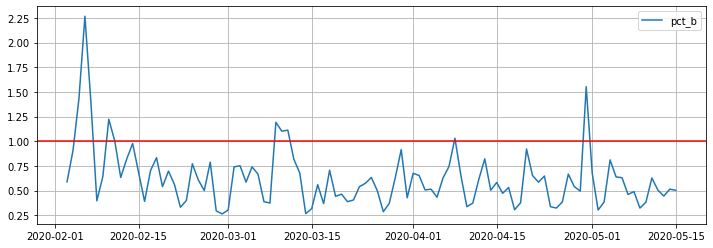

In [60]:
plt.figure(figsize=(12,4))
plt.plot(curie_n.pct_b, label = 'pct_b')
plt.grid()
plt.axhline(y=1.0, color='r', linestyle='-')
plt.legend()

### Curie students were studying really hard on April 30th for quiz!!

****

In [73]:
page_view = curie.groupby('destination').count()

In [71]:
page_view = page_view.to_dict()

In [79]:
curie['views'] = curie['destination'].map(page_view['student_id'])

In [83]:
curie.sort_values('views', ascending = False)

,destination,student_id,cohort,ip,count,views
datetime,,,,,,
2020-02-07 08:21:32,/,584,55.0,98.106.20.59,1,865.0
2020-05-01 15:33:42,/,579,55.0,137.51.65.246,1,865.0
2020-03-04 20:09:29,/,587,55.0,65.251.10.182,1,865.0
2020-04-13 09:06:32,/,583,55.0,46.28.10.172,1,865.0
2020-02-24 14:36:40,/,591,55.0,98.106.20.59,1,865.0
...,...,...,...,...,...,...
2020-02-21 13:26:48,11-nlp/6-model,577,55.0,98.106.20.59,1,1.0
2020-04-13 12:09:28,10-anomaly-detection/5-detecting-with-clustering,581,55.0,73.191.188.174,1,1.0
2020-02-19 11:38:00,4-python/7.5-intro-to-seaborn,579,55.0,98.106.20.59,1,1.0


In [88]:
top_10 = curie.groupby('destination').count().sort_values('count', ascending = False).iloc[0:11]

In [90]:
top_10

,student_id,cohort,ip,count,views
destination,,,,,
/,865,865,865,865,865
6-regression/1-overview,446,446,446,446,446
1-fundamentals/modern-data-scientist.jpg,410,410,410,410,410
1-fundamentals/AI-ML-DL-timeline.jpg,408,408,408,408,408
1-fundamentals/1.1-intro-to-data-science,405,405,405,405,405
3-sql/1-mysql-overview,365,365,365,365,365
search/search_index.json,307,307,307,307,307
4-python/8.4.3-dataframes,255,255,255,255,255
4-python/8.4.4-advanced-dataframes,234,234,234,234,234


In [ ]:
df.loc['2019-04-04': '2019-06-30'][pd.df.cohort.isna == True]

In [129]:
ada = df[pd.isna(df.cohort) == True].loc['2019-02-03': '2019-06-30']

In [130]:
ada.student_id.unique()

array([349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369,  58,  54, 372, 375,  48,
        88,  63, 403, 166, 406, 429])

In [131]:
ada

,destination,student_id,cohort,ip
datetime,,,,
2019-02-04 16:22:20,/,349,NaN,98.106.20.59
2019-02-04 16:22:36,/,350,NaN,98.106.20.59
2019-02-04 16:23:07,1._Fundamentals,350,NaN,98.106.20.59
2019-02-04 16:23:34,/,351,NaN,98.106.20.59
2019-02-04 16:36:36,/,352,NaN,98.106.20.59
...,...,...,...,...
2019-06-30 13:42:10,9.2_Detect_through_Probability,349,NaN,25.161.140.9
2019-06-30 13:56:07,3.0-mysql-overview,429,NaN,69.202.220.224
2019-06-30 13:56:09,4.2_data_types_and_variables,429,NaN,69.202.220.224


In [183]:
ada_list = pd.Series([349, 350, 351, 352, 353, 354, 355, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369,  372])

In [185]:
ada = df[df['student_id'].isin(ada_list)]

In [190]:
ada.loc['2019-12-01': '2020-05-15']

,destination,student_id,cohort,ip
datetime,,,,
2019-12-01 19:55:39,/,362,NaN,71.124.194.101
2019-12-02 13:08:43,/,352,NaN,105.192.14.220
2019-12-02 13:08:47,1-fundamentals/1.2-data-science-pipeline,352,NaN,105.192.14.220
2019-12-02 13:08:47,1-fundamentals/DataToAction_v2.jpg,352,NaN,105.192.14.220
2019-12-02 13:56:23,1-fundamentals/1.3-pipeline-demo,352,NaN,105.192.14.220
...,...,...,...,...
2020-05-13 16:30:22,8-clustering/project,349,NaN,157.81.5.3
2020-05-13 16:30:38,8-clustering/5-model,349,NaN,157.81.5.3
2020-05-13 17:36:13,/,366,NaN,100.89.63.138


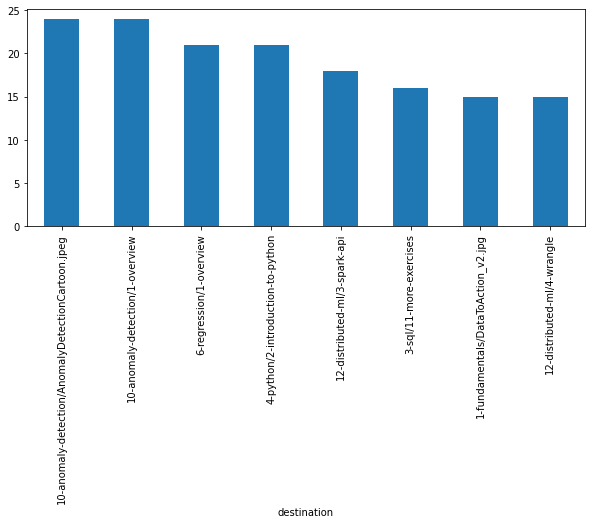

In [262]:
ada.loc['2019-12-01': '2020-05-15'].groupby('destination').count().sort_values('student_id', ascending = False).rename(columns = {'student_id': 'view_count'}).iloc[2:10].view_count.plot.bar(figsize=(10,4), label = 'views')
plt.show()

In [249]:
ada_views = ada.loc['2019-12-01': '2020-05-15'].groupby('destination').count().sort_values('student_id', ascending = False).rename(columns = {'student_id': 'view_count'})
ada_views

,view_count,cohort,ip
destination,,,
/,226,7,226
search/search_index.json,91,37,91
10-anomaly-detection/AnomalyDetectionCartoon.jpeg,24,19,24
10-anomaly-detection/1-overview,24,19,24
6-regression/1-overview,21,15,21
...,...,...,...
5-stats/Selecting_a_hypothesis_test.svg,1,0,1
5-stats/4.5-more-statistical-testing-examples,1,0,1
5-stats/4.4-compare-group-membership,1,1,1


In [223]:
bayes = df[df.cohort == 34]

In [225]:
bayes.student_id.unique()

array([466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 358, 487, 650])

In [236]:
bayes_list = [466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 358]

In [239]:
bayes = df[df.student_id.isin(bayes_list)]

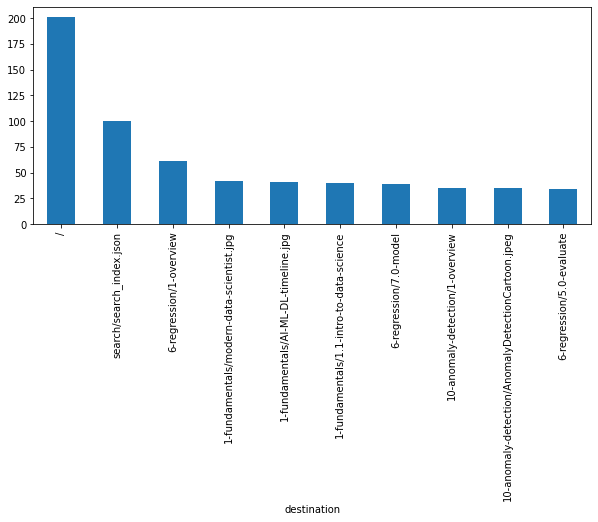

In [247]:
bayes.loc['2020-02-01': '2020-05-15'].groupby('destination').count().sort_values('student_id', ascending = False).rename(columns = {'student_id': 'view_count'}).iloc[0:10].view_count.plot.bar(figsize=(10,4))

In [250]:
bayes_views = bayes.loc['2020-02-01': '2020-05-15'].groupby('destination').count().sort_values('student_id', ascending = False).rename(columns = {'student_id': 'view_count'})

In [251]:
bayes_views

,view_count,cohort,ip
destination,,,
/,201,201,201
search/search_index.json,100,100,100
6-regression/1-overview,61,61,61
1-fundamentals/modern-data-scientist.jpg,42,42,42
1-fundamentals/AI-ML-DL-timeline.jpg,41,41,41
...,...,...,...
2-storytelling/3.6-creating-stories,1,1,1
8-clustering/5-model,1,1,1
3-sql/11-more-exercises,1,1,1


In [252]:
views = pd.concat([ada_views,bayes_views])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

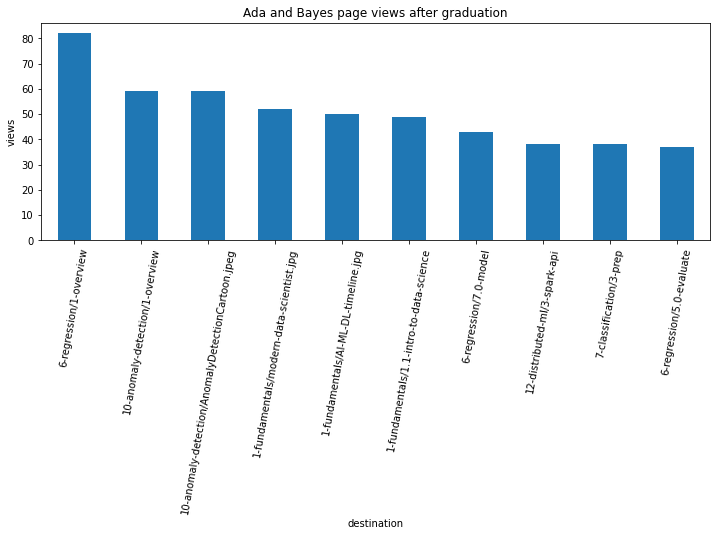

In [270]:
views.groupby('destination').sum().sort_values('view_count', ascending = False).view_count.iloc[2:12].plot.bar(figsize = (12,4), label = 'views')
plt.ylabel('views')
plt.title('Ada and Bayes page views after graduation')
plt.xticks(rotation = 80)

In [271]:
instructors = df[df.cohort == 28]

In [273]:
instructors.student_id.unique()

array([ 53, 314,  40,  64,  11, 211,   1, 312, 146, 248, 370, 397, 404,
       257, 428, 461,  37, 514, 539, 545, 546, 572, 315,  41, 592, 618,
       620])

In [294]:
df[df.student_id == 37]

,destination,student_id,cohort,ip
datetime,,,,
2018-01-26 12:37:53,/,37,19.0,193.172.118.211
2018-01-26 12:37:54,mkdocs/search_index.json,37,19.0,193.172.118.211
2018-01-26 12:38:12,content/javascript/objects/math.html,37,19.0,193.172.118.211
2018-01-26 12:38:19,content/laravel/quickstart/sessions.html,37,19.0,193.172.118.211
2018-02-18 22:51:52,/,37,19.0,174.176.118.45
...,...,...,...,...
2019-09-25 15:46:22,content/laravel/quickstart/gitbook/images/favi...,37,28.0,98.106.20.59
2019-09-25 15:46:32,content/laravel/more-features/readme.html,37,28.0,98.106.20.59
2019-09-25 15:46:32,content/laravel/more-features/gitbook/images/f...,37,28.0,98.106.20.59


In [300]:
df = df.destination.dropna()

In [309]:
def get_topic(destination):
    ds_list = ["python", "time series", "nlp"]
    web_dev = ["javascript", "java", "css"]
    for ds in ds_list:
        if ds in destination:
            return "Data Science"
    for wd in web_dev:
        if wd in destination:
            return "Web Dev"
    return "Unknown"

In [317]:
df["course"] = df.destination.apply(get_topic)

In [315]:
df.loc['2020-04-08 09:25:18'].destination = '2-storytelling/2.2-create'

In [320]:
df[df.course == 'Unknown']

,destination,student_id,cohort,ip,course
datetime,,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62,Unknown
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62,Unknown
2018-01-26 09:59:22,mkdocs/search_index.json,5,22.0,98.106.20.62,Unknown
2018-01-26 10:00:37,/,6,22.0,98.106.20.62,Unknown
2018-01-26 10:08:22,mkdocs/search_index.json,10,21.0,98.106.20.62,Unknown
...,...,...,...,...,...
2020-05-15 15:00:27,spring/fundamentals/form-model-binding,120,53.0,105.49.214.176,Unknown
2020-05-15 15:00:58,9-timeseries/4-explore,588,55.0,71.95.165.84,Unknown
2020-05-15 15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38,Unknown


In [323]:
ds = pd.concat([ada, bayes, curie])

In [331]:
ds = ds.drop(columns =  'views')

In [332]:
ds

,cohort,destination,ip,student_id
datetime,,,,
2019-02-04 16:22:20,NaN,/,98.106.20.59,349
2019-02-04 16:22:36,NaN,/,98.106.20.59,350
2019-02-04 16:23:07,NaN,1._Fundamentals,98.106.20.59,350
2019-02-04 16:23:34,NaN,/,98.106.20.59,351
2019-02-04 16:36:36,NaN,/,98.106.20.59,352
...,...,...,...,...
2020-05-15 14:46:46,55.0,search/search_index.json,174.176.101.202,591
2020-05-15 14:47:01,55.0,appendix/professional-development/t-block-less...,174.176.101.202,591
2020-05-15 14:49:50,55.0,appendix/professional-development/vertical-resume,174.176.101.202,591


In [353]:
ds['cohort'] = ds.cohort.fillna(100)

In [355]:
ds = ds.dropna()

In [357]:
ds.head(3)

,cohort,destination,ip,student_id
datetime,,,,
2019-02-04 16:22:20,100.0,/,98.106.20.59,349
2019-02-04 16:22:36,100.0,/,98.106.20.59,350
2019-02-04 16:23:07,100.0,1._Fundamentals,98.106.20.59,350


In [366]:
ada_size = ds[ds.cohort == 100].student_id.nunique()
curie_size = ds[ds.cohort == 55].student_id.nunique()
bayes_size = ds[ds.cohort == 34].student_id.nunique()

In [369]:
ds_sampled = ds.resample('H').count()

In [372]:
ds_sampled['hour'] = ds_sampled.index.hour

In [373]:
ds_sampled.head(4)

,cohort,destination,ip,student_id,hour
datetime,,,,,
2019-02-04 16:00:00,24,24,24,24,16
2019-02-04 17:00:00,2,2,2,2,17
2019-02-04 18:00:00,0,0,0,0,18
2019-02-04 19:00:00,0,0,0,0,19


In [376]:
ds_af = ds_sampled[(ds_sampled['hour']<8) | (ds_sampled['hour']>5)]

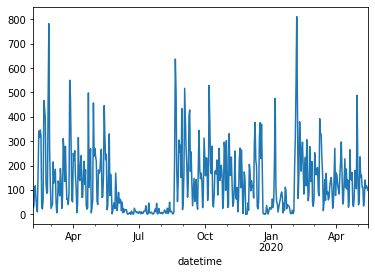

In [385]:
ds_af.resample('D').sum().ip.plot()

In [389]:
ada_sampled = ada.resample('H').count()
bayes_sampled = bayes.resample('H').count()
curie_sampled = curie.resample('H').count()

In [390]:
ada_sampled['hour'] = ada_sampled.index.hour
bayes_sampled['hour'] = bayes_sampled.index.hour
curie_sampled['hour'] = curie_sampled.index.hour

In [395]:
ada_af = ada_sampled[(ada_sampled['hour']<8) | (ada_sampled['hour']>5)]/ada_size
bayes_af = bayes_sampled[(bayes_sampled['hour']<8) | (bayes_sampled['hour']>5)]/bayes_size
curie_af = curie_sampled[(curie_sampled['hour']<8) | (curie_sampled['hour']>5)]/curie_size

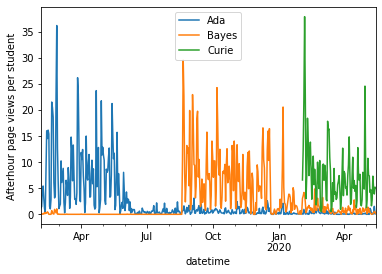

In [402]:
ada_af.resample('D').sum().ip.plot(label = 'Ada')
bayes_af.resample('D').sum().ip.plot(label = 'Bayes')
curie_af.resample('D').sum().ip.plot(label = 'Curie')

plt.ylabel('Afterhour page views per student')
plt.legend()

In [419]:
ada_stat = ada_af.loc['2019-02-01': '2019-06-15'].resample('M').sum().iloc[:,:1]

In [420]:
bayes_stat = bayes_af.loc['2019-09-01': '2020-01-15'].resample('M').sum().iloc[:,:1]

In [421]:
curie_stat = curie_af.loc['2020-02-03': '2020-05-15'].resample('M').sum().iloc[:,:1]

In [435]:
ada_stat['month'] = [1,2,3,4,5]
bayes_stat['month'] = [1,2,3,4,5]
curie_stat['month'] = [1,2,3,4]

In [456]:
bayes_stat

,destination,month
datetime,,
2019-09-30,238.142857,1
2019-10-31,258.714286,2
2019-11-30,151.523810,3
2019-12-31,163.523810,4
2020-01-31,56.142857,5


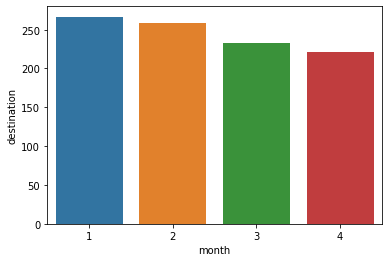

In [436]:
sns.barplot(x = 'month', y = 'destination', data = ada_stat)
sns.barplot(x = 'month', y = 'destination', data = bayes_stat)
sns.barplot(x = 'month', y = 'destination', data = curie_stat)

In [460]:
data = pd.concat([ada_stat.reset_index().drop(columns = ['datetime','month']),bayes_stat.reset_index().drop(columns = 'datetime'),curie_stat.reset_index().drop(columns = ['datetime','month'])], axis =1)
          

In [462]:
data.columns = ['Ada', 'Bayes', 'month', 'Curie']

In [463]:
data

,Ada,Bayes,month,Curie
0,244.238095,238.142857,1,266.684211
1,211.000000,258.714286,2,204.210526
2,233.190476,151.523810,3,201.421053
3,221.809524,163.523810,4,77.736842
4,22.619048,56.142857,5,NaN


Text(0.5, 1.0, 'Afterhours pageviews per student by month')

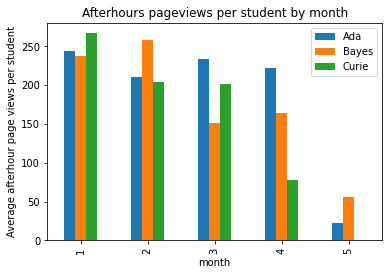

In [478]:
data.plot.bar(x = 'month', y = ['Ada', 'Bayes', 'Curie'])
plt.ylabel('Average afterhour page views per student')
plt.title('Afterhours pageviews per student by month')

In [475]:
df[df.cohort==34]

,destination,student_id,cohort,ip,course
datetime,,,,,
2019-08-20 09:39:58,/,466,34.0,98.106.20.59,Unknown
2019-08-20 09:39:59,/,467,34.0,98.106.20.59,Unknown
2019-08-20 09:39:59,/,468,34.0,98.106.20.59,Unknown
2019-08-20 09:40:02,/,469,34.0,98.106.20.59,Unknown
2019-08-20 09:40:08,/,470,34.0,98.106.20.59,Unknown
...,...,...,...,...,...
2020-05-14 16:37:14,9-timeseries/working-with-time-series-data-wit...,476,34.0,137.51.50.146,Unknown
2020-05-14 16:37:17,9-timeseries/3-prep,476,34.0,137.51.50.146,Unknown
2020-05-15 08:13:51,13-advanced-topics/2-cross-validation,479,34.0,173.15.107.32,Unknown
